In [258]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
%matplotlib inline

### Data

In [129]:
def load_data(file):
    ans = {}
    last = ""
    with open(file) as f:
        for line in f:
            tmp = line.strip().split()
            
            if tmp[0] == 'NAME:':
                ans['name'] = tmp[1]
                last = tmp[0]
            
            elif tmp[0] == "DIMENSION:":
                ans['n'] = int(tmp[1])
                last = tmp[0]
                
            elif tmp[0] == "DIMENSION":
                ans['n'] = int(tmp[2]) # the files with opt tour are different....
                last = tmp[0]
            
            elif tmp[0] == "EDGE_WEIGHT_SECTION":
                last = tmp[0]
            
            elif tmp[0] == "DISPLAY_DATA_SECTION" or tmp[0] == "NODE_COORD_SECTION":
                last = tmp[0]
            
            #in case we are reading the optimal tour file
            elif tmp[0] == "TOUR_SECTION": 
                last = tmp[0]
            
            elif tmp[0] == "EOF":
                last = tmp[0]
                break
                
            else:
                if last == "EDGE_WEIGHT_SECTION":
                    tmp = np.array( list ( map ( int, tmp ) ) )
                    #if our distance matrix is not fully given
                    if len(tmp) < 29: 
                        tmp = np.hstack((np.zeros( 29 - len(tmp)), tmp))
                        
                    if 'dist' in ans:
                        ans['dist'] = np.vstack((ans['dist'], tmp))
                    else:
                        ans['dist'] = tmp
                    
                if last == "DISPLAY_DATA_SECTION" or last == "NODE_COORD_SECTION":
                    tmp = list ( map ( float, tmp[1:] ) )
                    if 'coords' in ans:
                        ans['coords'] = np.vstack((ans['coords'], np.array(tmp)) )
                    else:
                        ans['coords'] = np.array(tmp)
                
                if last == "TOUR_SECTION" and tmp[0] != '-1':
                    tmp = int(tmp[0])
                    if 'p' in ans:
                        ans['p'].append(tmp - 1)
                    else:
                        ans['p'] = [tmp - 1]
    return ans

In [130]:
def plot_costs(c_min, data, opt, name):
    plt.figure(figsize=(12,4))
    plt.title(f'Costs of {name}\nfound minimum: {c_min:.3f}, optimal:{opt:.3f}', fontdict = {'fontsize' : 20})
    plt.plot(data[:,0], label="Top scores")
    plt.plot(data[:,1], label="Mean scores")
    plt.plot(data[:,2], label="Worst scores")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend(loc='upper right')
    plt.show()

    
def plot_histogram(costs):
    plt.figure(figsize=(12,4))
    plt.xlim(7500, 9200)
    plt.hist(costs, bins=150)
    plt.title("Histogram of costs")
    plt.xlabel("Cost")
    plt.ylabel("Number of results")
    plt.show()
    

### Mutations

In [131]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

In [265]:
#function to check all permutations that differs by at most K swaps

def local_search_mutation(p, K = 1):
    
    n = len(p)
    
    # in case we cant permutate (K = 0) or the only permutation is p
    if K == 0 or n == 1:
        return p # p is a numpy array
    
    # base case of recursion 
    if n <= 0:
        return np.array([])
    
    
    permutations = []
    for i in range(0, n):
        tmp = p.copy()
        tmp[0], tmp[i] = tmp[i], tmp[0]
        if i == 0:
            best_perm = np.concatenate((tmp[:1], local_search_mutation(tmp[1:], K)))
        else:
            best_perm = np.concatenate((tmp[:1], local_search_mutation(tmp[1:], K - 1)))
        
        '''#best_perm = tmp[0] + local_search_mutation(tmp[1:], K - 1)
        if i == 0:
            best_perm = [tmp[0]] + local_search_mutation(tmp[1:], K, True)
            #tmp_perm = local_search_mutation(tmp[1:], K, True)
            #print(best_perm, tmp[0], local_search_mutation(tmp[1:], K, True))
        else:
            if first:
                best_perm = [tmp[0]] + local_search_mutation(tmp[1:], K - 2)
                #tmp_perm = local_search_mutation(tmp[1:], K - 2)
                #print(best_perm, tmp[0], local_search_mutation(tmp[1:], K - 2))
            else:
                best_perm = [tmp[0]] + local_search_mutation(tmp[1:], K - 1)
                #tmp_perm = local_search_mutation(tmp[1:], K - 1)
                #print(best_perm, tmp[0], local_search_mutation(tmp[1:], K - 1))'''
                
        permutations.append((best_perm, tsp_objective_function(best_perm)))
    
    return min(permutations, key = lambda k: k[1])[0]        

In [284]:
def local_iter_search_mutation(p, K = 1):
    curr_score = tsp_objective_function(p)
    q = local_search_mutation(p, K)
    mut_score = tsp_objective_function(q)
    while(mut_score < curr_score):
        curr_score = mut_score
        p = q
        q = local_search_mutation(p, K)
        mut_score = tsp_objective_function(q)
    return p

### SGA algorithm

In [102]:
#Partialy Mapped Crossover
def PMX(ind1, ind2):
    a = np.random.choice(len(ind1), 2, False)
    i, j = a.min(), a.max()
    p1 = ind1[i:j+1]
    p2 = ind2[i:j+1]
    d_p1 = {p1[k] : p2[k] for k in range(len(p1))}
    d_p2 = {p2[k] : p1[k] for k in range(len(p2))}
    child1 = ind1.copy()
    child2 = ind2.copy()
    
    child1[i:j+1] = p2
    child2[i:j+1] = p1
    
    for k in range(i):
        while child1[k] in d_p2:
            child1[k] = d_p2[child1[k]]
        while child2[k] in d_p1:
            child2[k] = d_p1[child2[k]]
            
    for k in range(j+1, len(ind1)):
        s = 0
        while child1[k] in d_p2:
            child1[k] = d_p2[child1[k]]
            
        while child2[k] in d_p1:
            child2[k] = d_p1[child2[k]]
        
    return child2, child1

In [103]:
#Order Crossover
def OX(ind1, ind2):
    a = np.random.choice(len(ind1), 2, False)
    g_start, g_end = a.min(), a.max() # index of group split
    
    groups = []
    if g_start > 0:
        groups.append((0, g_start - 1))
    groups.append((g_start, g_end))
    if g_end < len(ind1) - 1:
        groups.append((g_end + 1, len(ind1) - 1))
        
    # rand index of group we want to inherit
    r = np.random.choice(len(groups))
    i, j = groups[r][0], groups[r][1]
    
    # fragments to inherit
    p1 = ind1[i:j+1]
    p2 = ind2[i:j+1]
    d_p1 = set(p1[k] for k in range(len(p1)))
    d_p2 = set(p2[k] for k in range(len(p2)))
    
    child1 = list(range(len(ind1)))
    child2 = list(range(len(ind2)))
    
    el_for_c1 = []
    el_for_c2 = []
    
    for k in range(j + 1, len(ind1)):
        if ind2[k] not in d_p1:
            el_for_c1.append(ind2[k])
        if ind1[k] not in d_p2:
            el_for_c2.append(ind1[k])
    
    for k in range(0, j + 1):
        if ind2[k] not in d_p1:
            el_for_c1.append(ind2[k])
        if ind1[k] not in d_p2:
            el_for_c2.append(ind1[k])
    
    child1[i:j+1] = p1
    child2[i:j+1] = p2
    
    idx = 0
    
    for k in range(j + 1, len(ind1)):
        child1[k] = el_for_c1[idx]
        child2[k] = el_for_c2[idx]
        idx += 1
    
    for k in range(0, i):
        child1[k] = el_for_c1[idx]
        child2[k] = el_for_c2[idx]
        idx += 1
        
    return child1, child2

In [109]:
def tsp_objective_function(p):
    s = 0.0
    for i in range(len(p)):
        s += A[p[i-1], p[i]]
    return s

In [263]:
def SGA(F, operator = PMX, number_of_iterations = 250, return_chromosome = False):
    population_size = 500
    chromosome_length = n
    number_of_offspring = population_size
    crossover_probability = 0.95
    mutation_probability = 0.25

    time0 = time.time()

    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))
    
    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = tsp_objective_function(current_population[i, :])
    
    costs = np.zeros((number_of_iterations, 3)) # we will keep best, mean and worst cost in i-th iteration
    for t in tqdm(range(number_of_iterations)):
        
        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = operator(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        
        # uzywac dwoch roznych mutacji #
        
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = F(children_population[i, :])

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = tsp_objective_function(children_population[i, :])

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]
        
        # recording some statistics
        
        costs[t][0] = objective_values[0]
        costs[t][1] = objective_values.mean()
        costs[t][2] = objective_values[-1]
        
        if best_objective_value > objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]
    
        #print(best_chromosome)
        #print('%3d %14.8f %12.8f %12.8f %12.8f %12.8f' % (t, time.time() - time0, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))
    #print("s_g_a time:", time.time() - time0)
    if return_chromosome:
        return best_objective_value, costs, best_chromosome
    return best_objective_value, costs

### Berlin52

In [256]:
data = load_data("berlin52.tsp.txt")
n = data['n']
print('Problem size: %d' % n)

coords = data['coords']

# compute a distance matrix
A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())

opt = load_data("berlin52.opt.tour.txt")
p = opt['p']
opt = tsp_objective_function(p)

print(opt, ' -> optimal solution:\n', p)


Problem size: 52
7544.365901904086  -> optimal solution:
 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


In [266]:
data = {} # dict of operator: list of (c_min, costs) in i-th iteration
data['ls + pmx'] = list()
for i in range(5):
    data['ls + pmx'].append(SGA(local_search_mutation, operator = PMX))

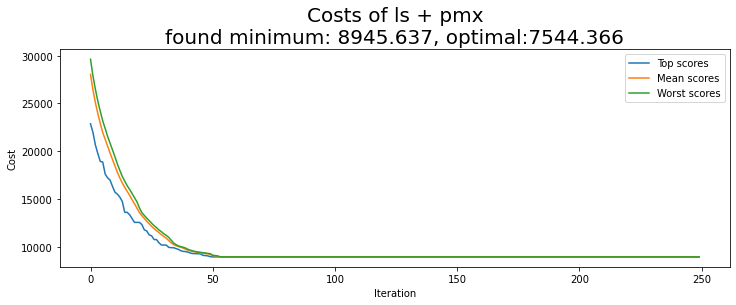

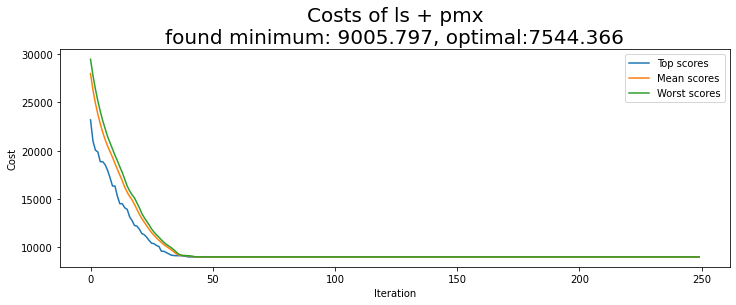

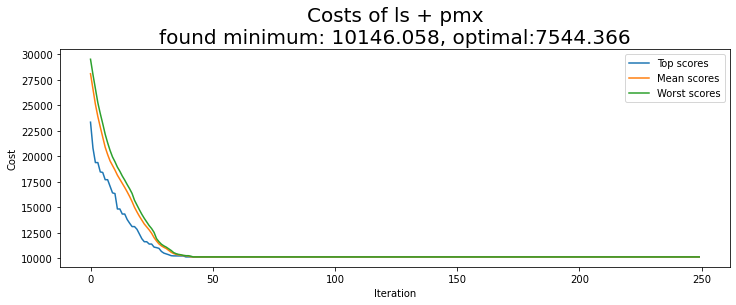

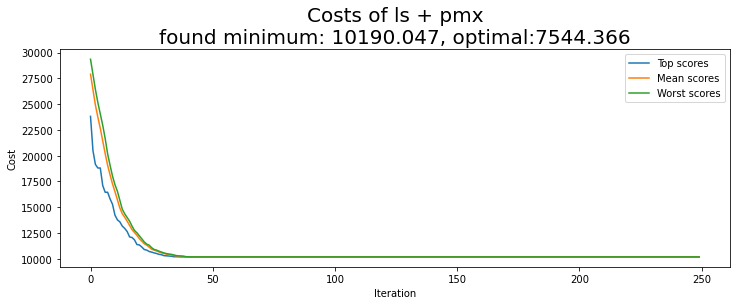

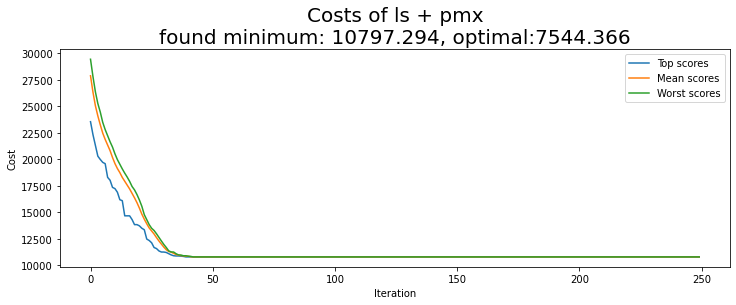

Mean: 9816.966779785953, Std: 724.6714544030701


In [280]:
avgs = []
for d in data['ls + pmx']:
    plot_costs(d[0], d[1], opt, 'ls + pmx')
costs = np.array([c[0] for c in data['ls + pmx']])
avgs.append(costs.mean())
print(f'Mean: {costs.mean()}, Std: {costs.std()}')

In [289]:
data['lsi + pmx'] = list()
for i in range(10):
    data['lsi + pmx'].append(SGA(local_iter_search_mutation, operator = PMX))

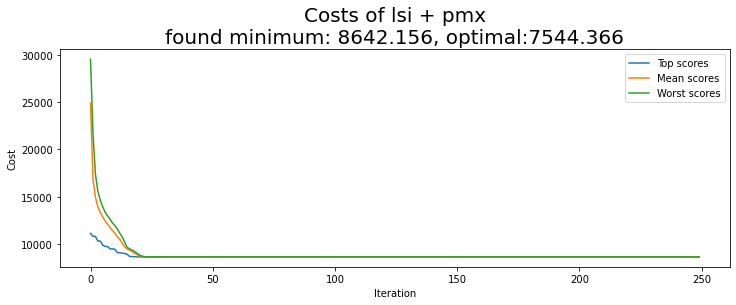

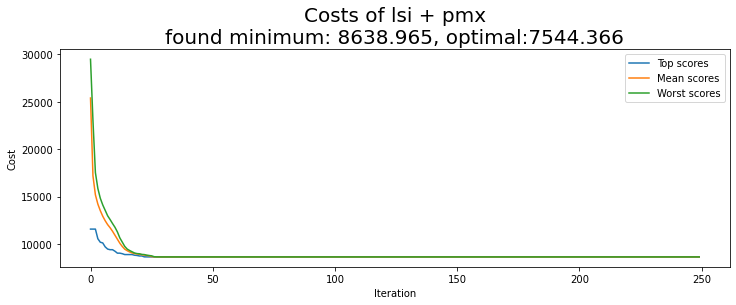

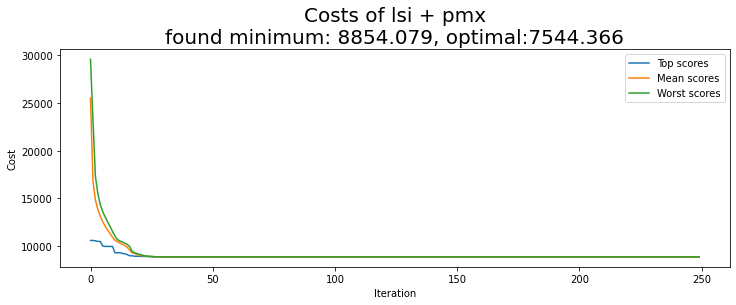

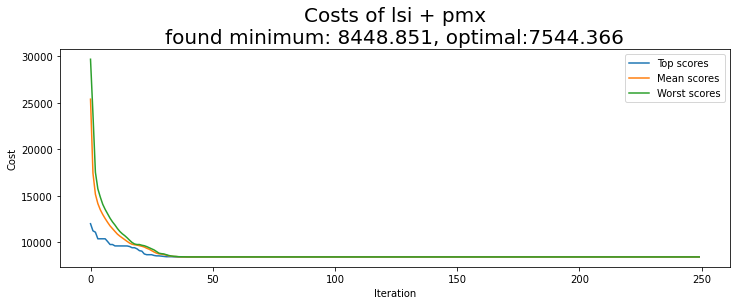

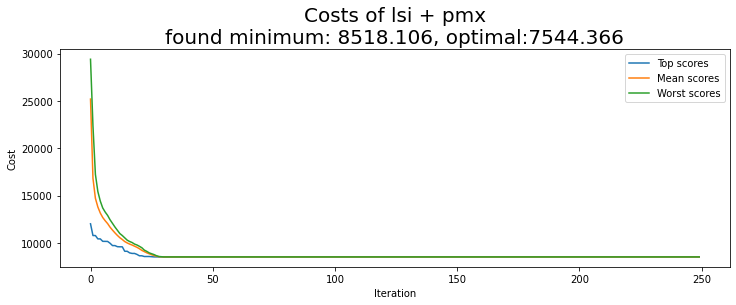

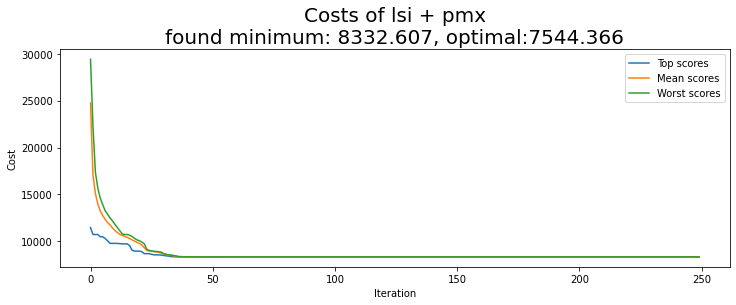

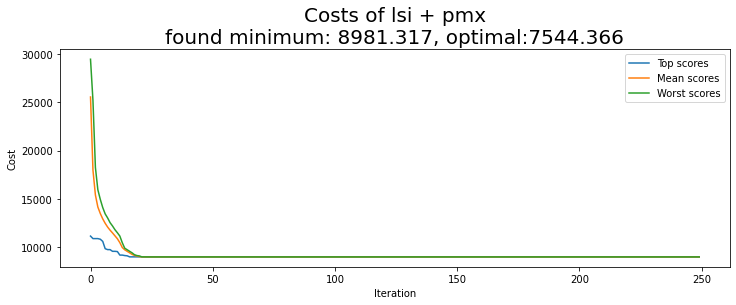

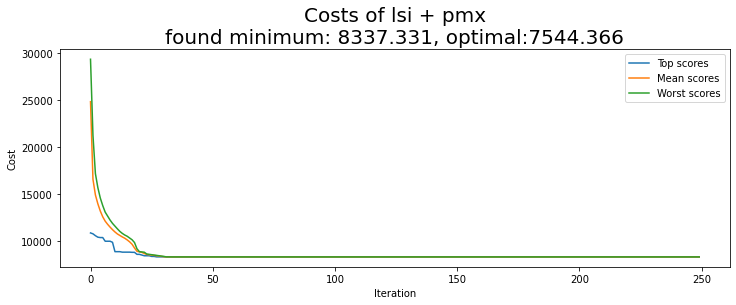

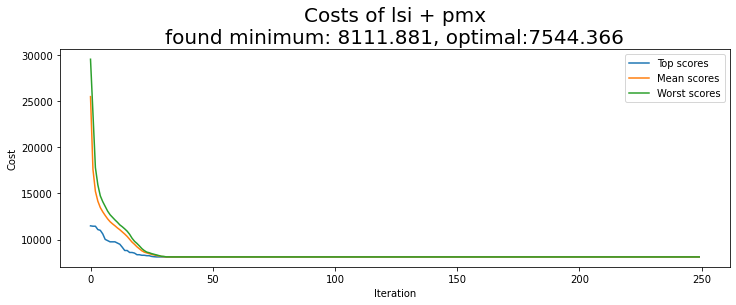

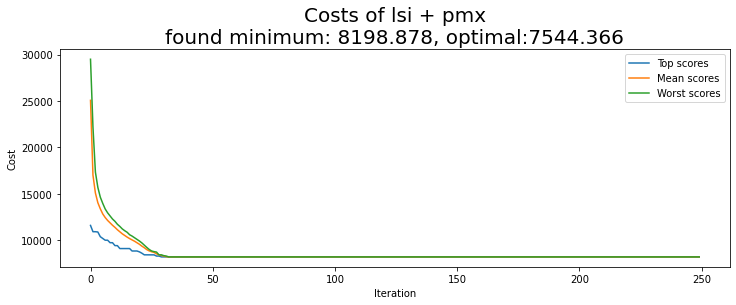

Mean: 8506.417076129605, Std: 263.60631992412624


In [291]:
for d in data['lsi + pmx']:
    plot_costs(d[0], d[1], opt, 'lsi + pmx')
costs = np.array([c[0] for c in data['lsi + pmx']])
avgs.append(costs.mean())
print(f'Mean: {costs.mean()}, Std: {costs.std()}')